# Importing the Dependencies

In [1]:
import requests
import lxml.html as lh
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
!pip install folium
import folium
import collections 
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

     |████████████████████████████████| 102kB 6.8MB/s ta 0:00:011


# Scraping the Neighborhoods in Mumbai from the Wikipedia Page

In [2]:
URL = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai#Antop_Hill'
mumbai_page = requests.get(URL)

doc = lh.fromstring(mumbai_page.content)

rows = doc.xpath('//tr')

In [3]:
cols = []

for column in rows[0]:
    cols.append(column.text_content()[:-1])
    
cols

['Area', 'Location', 'Latitude', 'Longitude']

In [4]:
data = []

for index, r in enumerate(rows):
    if index > 0:   
        row = []
        for value in r:
            row.append(value.text_content()[:-1])
        data.append(row)

In [5]:
mumbai_neighborhood = pd.DataFrame(data, columns=cols)

mumbai_neighborhood.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.1293,72.8434
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.82721
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.82927


In [6]:
mumbai_neighborhood.shape

(93, 4)

# Downloading the Commercial Property Rate Data

In [7]:
url = 'https://drive.google.com/uc?export=download&id=1a2lBIVAgxwIPtavdJh7CLpObKaxXxuB9'
mumbai_property_rates = pd.read_csv(url)
mumbai_property_rates.head()

,Area,Location,Rate
0,Amboli,"Andheri,Western Suburbs",18000.0
1,"Chakala, Andheri",Western Suburbs,14750.0
2,D.N. Nagar,"Andheri,Western Suburbs",18000.0
3,Four Bungalows,"Andheri,Western Suburbs",18000.0
4,Lokhandwala,"Andheri,Western Suburbs",18000.0


In [8]:
mumbai_data = pd.merge(mumbai_neighborhood, mumbai_property_rates, on=['Area', 'Location'])
mumbai_data.dropna(inplace=True)

new = mumbai_data["Location"].str.split(",", n = 1, expand = True) 
mumbai_data["Location"] = new[0] 
mumbai_data["Suburb"]= new[1] 

for i in range(mumbai_data.shape[0]):
    if mumbai_data.iloc[i, 5] is None:
        mumbai_data.iloc[i, 5] = mumbai_data.iloc[i, 1]

mumbai_data.reset_index(drop=True, inplace=True)

mumbai_data.head()

,Area,Location,Latitude,Longitude,Rate,Suburb
0,Amboli,Andheri,19.1293,72.8434,18000.0,Western Suburbs
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,14750.0,Western Suburbs
2,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs
3,Four Bungalows,Andheri,19.124714,72.82721,18000.0,Western Suburbs
4,Lokhandwala,Andheri,19.130815,72.82927,18000.0,Western Suburbs


In [9]:
mumbai_data.at[62, 'Longitude'] = 72.8478

mumbai_data.shape

(67, 6)

# Using the FourSquare API to find Restaurants near our neighborhoods

In [10]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 
VERSION = '20180604'

In [11]:
LIMIT = 100
radius = 1000
venues = []

for latitude, longitude in zip(mumbai_data['Latitude'], mumbai_data['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    venues.append(requests.get(url).json())

In [12]:
food_joints = []
all_joints = []

for i in range(len(venues)):
    joints = []
    for j in range(len(venues[i]['response']['venues'])):
        try:
            if '/food/' in venues[i]['response']['venues'][j]['categories'][0]['icon']['prefix']:
                joints.append(str(venues[i]['response']['venues'][j]['categories'][0]['name']))
        except:
            pass
    food_joints.append(joints)
    
for i in range(len(venues)):
    joints = []
    for j in range(len(venues[i]['response']['venues'])):
        try:
            joints.append(str(venues[i]['response']['venues'][j]['categories'][0]['name']))
        except:
            pass
    all_joints.append(joints)

In [13]:
mumbai_data['Food Joints'] = food_joints
mumbai_data['All Joints'] = all_joints

mumbai_data.reset_index(drop=True, inplace = True) 

In [14]:
mumbai_data.head()

,Area,Location,Latitude,Longitude,Rate,Suburb,Food Joints,All Joints
0,Amboli,Andheri,19.1293,72.8434,18000.0,Western Suburbs,"[Ice Cream Shop, Vegetarian / Vegan Restaurant...","[Playground, Ice Cream Shop, Residential Build..."
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,14750.0,Western Suburbs,"[Asian Restaurant, Asian Restaurant, Indian Re...","[Asian Restaurant, Asian Restaurant, Indian Re..."
2,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs,"[Seafood Restaurant, Ice Cream Shop, Restauran...","[Post Office, Seafood Restaurant, High School,..."
3,Four Bungalows,Andheri,19.124714,72.82721,18000.0,Western Suburbs,"[Burger Joint, Snack Place, Cupcake Shop, Bake...","[Residential Building (Apartment / Condo), Sal..."
4,Lokhandwala,Andheri,19.130815,72.82927,18000.0,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Coffee ...","[Supermarket, Light Rail Station, Accessories ..."


# Exploratory Data Analysis

## Considering all venues near a Neighborhood

In [15]:
latitude = []
longitude = []
suburbs = []
area = []
category = []

for i in range(len(venues)):
    count = 0
    for j in range(len(venues[i]['response']['venues'])):
        try:
            latitude.append(venues[i]['response']['venues'][j]['location']['lat'])
            longitude.append(venues[i]['response']['venues'][j]['location']['lng'])
            category.append(venues[i]['response']['venues'][j]['categories'][0]['name'])
        except:
            pass
    suburbs.extend([mumbai_data.iloc[i, 5]]*len(mumbai_data.iloc[i, 7]))
    area.extend([mumbai_data.iloc[i, 0]]*len(mumbai_data.iloc[i, 7]))

In [16]:
restaurants = []

for joints in mumbai_data['All Joints']:
    restaurants.extend(joints)

restaurants = pd.DataFrame({'Category':restaurants, 'Suburbs':suburbs, 'Area':area}, columns=['Category', 'Suburbs', 'Area'])
restaurants = restaurants.merge(mumbai_data.set_index('Area'), on='Area')
restaurants.drop(['Food Joints'], axis = 1, inplace = True)

In [17]:
restaurant_onehot = pd.get_dummies(restaurants['Category'])

# add neighborhood column back to dataframe
restaurant_onehot['Suburb'] = restaurants['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_grouped = restaurant_onehot.groupby('Suburb').mean().reset_index()

num_top_venues = 5

for hood in restaurant_grouped['Suburb']:
    print("----"+hood+"----")
    temp = restaurant_grouped[restaurant_grouped['Suburb'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Eastern Suburbs----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.10
1                         Indian Restaurant  0.05
2                        Salon / Barbershop  0.03
3                                  Building  0.02
4                       Housing Development  0.02


----Harbour Suburbs----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.12
1                                      Bank  0.07
2                         Indian Restaurant  0.04
3                       Housing Development  0.03
4                                    Temple  0.02


----South Mumbai----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.09
1                                    Office  0.06
2                         Indian Restaurant  0.04
3                                      Bank  0.03
4                                  Building  0.03


----Western Suburbs----
 

## Considering only Food Venues near a Neighborhood

In [18]:
latitude = []
longitude = []
suburbs = []
area = []
category = []

for i in range(len(venues)):
    count = 0
    for j in range(len(venues[i]['response']['venues'])):
        try:
            if '/food/' in venues[i]['response']['venues'][j]['categories'][0]['icon']['prefix']:
                latitude.append(venues[i]['response']['venues'][j]['location']['lat'])
                longitude.append(venues[i]['response']['venues'][j]['location']['lng'])
                category.append(venues[i]['response']['venues'][j]['categories'][0]['name'])
        except:
            pass
    suburbs.extend([mumbai_data.iloc[i, 5]]*len(mumbai_data.iloc[i, 6]))
    area.extend([mumbai_data.iloc[i, 0]]*len(mumbai_data.iloc[i, 6]))

In [19]:
mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

suburb_names = ['Western Suburbs', 'Eastern Suburbs', 'Harbour Suburbs', 'South Mumbai']
colors = ['red', 'blue', 'green', 'yellow']

for lat, long, name, suburb in zip(latitude, longitude, category, suburbs):
    label = folium.Popup(str(name))
    folium.CircleMarker(
        [lat, long], 
        radius=5,
        popup=label,
        color=colors[suburb_names.index(suburb)],
        fill=True, 
        fill_opacity=0.7
    ).add_to(mumbai_map)
    
display(mumbai_map)

In [20]:
restaurants = []

for joints in mumbai_data['Food Joints']:
    restaurants.extend(joints)

restaurants = pd.DataFrame({'Category':restaurants, 'Suburbs':suburbs, 'Area':area}, columns=['Category', 'Suburbs', 'Area'])
restaurants = restaurants.merge(mumbai_data.set_index('Area'), on='Area')
restaurants.drop(['Food Joints'], axis = 1, inplace = True)

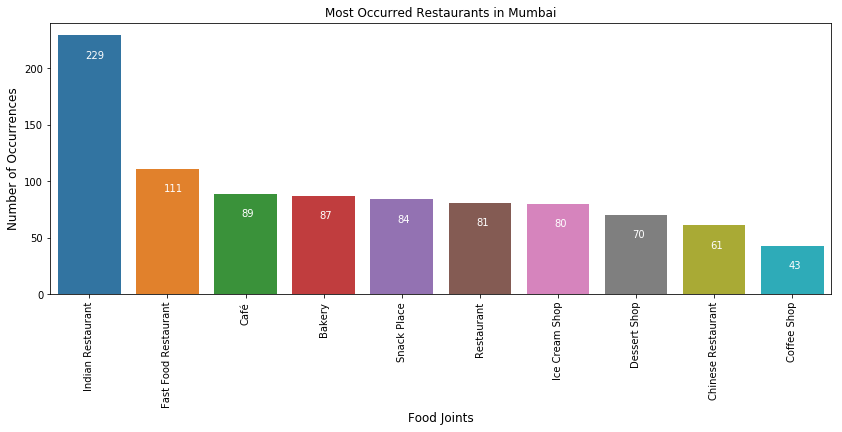

In [21]:
x = restaurants['Category'].value_counts()[:10].index
y = restaurants['Category'].value_counts()[:10].values

plt.figure(figsize=(14,5))
sns.barplot(x, y)
plt.xticks(rotation=90)
plt.title('Most Occurred Restaurants in Mumbai')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Food Joints', fontsize=12)

for index, value in enumerate(y):
    plt.annotate(value, xy=(index - 0.05, value - 20), color='white')

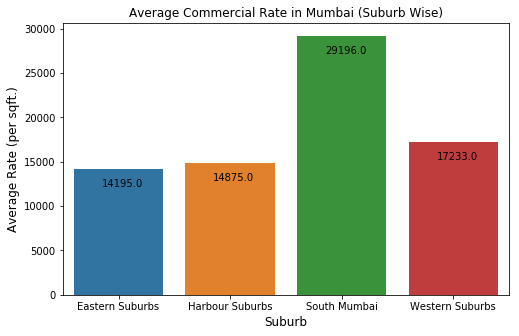

In [22]:
x = mumbai_data.groupby('Suburb')['Rate'].mean().index
y = np.round_(mumbai_data.groupby('Suburb')['Rate'].mean().values)

plt.figure(figsize=(8,5))
sns.barplot(x, y)
plt.title('Average Commercial Rate in Mumbai (Suburb Wise)')
plt.ylabel('Average Rate (per sqft.)', fontsize=12)
plt.xlabel('Suburb', fontsize=12)

for index, value in enumerate(y):
    plt.annotate(value, xy=(index - 0.15, value - 2000), color='black')

In [23]:
restaurant_onehot = pd.get_dummies(restaurants['Category'])

# add neighborhood column back to dataframe
restaurant_onehot['Suburb'] = restaurants['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_grouped = restaurant_onehot.groupby('Suburb').mean().reset_index()

restaurant_grouped.head()

,Suburb,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,...,Street Food Gathering,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery
0,Eastern Suburbs,0.004292,0.004292,0.00000,0.00000,0.00000,0.047210,0.004292,0.004292,0.004292,...,0.00000,0.008584,0.004292,0.000000,0.000000,0.000000,0.004292,0.00000,0.000000,0.000000
1,Harbour Suburbs,0.000000,0.030303,0.00000,0.00000,0.00000,0.060606,0.000000,0.000000,0.000000,...,0.00000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.060606
2,South Mumbai,0.002203,0.013216,0.00000,0.00000,0.00000,0.022026,0.000000,0.000000,0.008811,...,0.00000,0.008811,0.002203,0.002203,0.000000,0.004405,0.013216,0.00000,0.006608,0.002203
3,Western Suburbs,0.001330,0.006649,0.00266,0.00133,0.00133,0.021277,0.001330,0.000000,0.007979,...,0.00133,0.011968,0.001330,0.000000,0.003989,0.001330,0.013298,0.00133,0.002660,0.003989


In [24]:
num_top_venues = 5

for hood in restaurant_grouped['Suburb']:
    print("----"+hood+"----")
    temp = restaurant_grouped[restaurant_grouped['Suburb'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Eastern Suburbs----
                  venue  freq
0     Indian Restaurant  0.18
1  Fast Food Restaurant  0.08
2        Ice Cream Shop  0.06
3           Snack Place  0.06
4            Restaurant  0.06


----Harbour Suburbs----
                  venue  freq
0     Indian Restaurant  0.24
1  Fast Food Restaurant  0.12
2                Winery  0.06
3      Asian Restaurant  0.06
4                Bakery  0.06


----South Mumbai----
                  venue  freq
0     Indian Restaurant  0.17
1  Fast Food Restaurant  0.08
2                  Café  0.07
3        Ice Cream Shop  0.05
4                Bakery  0.05


----Western Suburbs----
                  venue  freq
0     Indian Restaurant  0.13
1  Fast Food Restaurant  0.07
2        Ice Cream Shop  0.06
3                Bakery  0.06
4           Snack Place  0.06




# Clustering Neighborhoods

In [25]:
restaurant_onehot = pd.get_dummies(restaurants['Category'])

# add neighborhood column back to dataframe
restaurant_onehot['Area'] = restaurants['Area'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_grouped = restaurant_onehot.groupby('Area').mean().reset_index()

restaurant_grouped.head()

,Area,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,...,Street Food Gathering,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery
0,Aarey Milk Colony,0.0,0.031250,0.03125,0.0,0.0,0.000000,0.031250,0.0,0.000000,...,0.0,0.062500,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Altamount Road,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Amboli,0.0,0.000000,0.00000,0.0,0.0,0.045455,0.000000,0.0,0.000000,...,0.0,0.045455,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.0
3,Amrut Nagar,0.0,0.038462,0.00000,0.0,0.0,0.076923,0.038462,0.0,0.038462,...,0.0,0.000000,0.038462,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Asalfa,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurant_sorted = pd.DataFrame(columns=columns)
restaurant_sorted['Area'] = restaurant_grouped['Area']

for ind in np.arange(restaurant_grouped.shape[0]):
    restaurant_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_grouped.iloc[ind, :], num_top_venues)

restaurant_sorted = restaurant_sorted.merge(mumbai_data[['Area', 'Rate']].set_index('Area'), on='Area')   

restaurant_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate
0,Aarey Milk Colony,Indian Restaurant,Snack Place,Café,Restaurant,Tea Room,Chinese Restaurant,American Restaurant,Chaat Place,Pizza Place,Fast Food Restaurant,12950.0
1,Altamount Road,Ice Cream Shop,Café,Fast Food Restaurant,Indian Restaurant,Restaurant,Food Truck,Cupcake Shop,Bakery,Dessert Shop,Donut Shop,45000.0
2,Amboli,Chinese Restaurant,Snack Place,Fast Food Restaurant,Restaurant,Indian Restaurant,Tea Room,Sandwich Place,Coffee Shop,Asian Restaurant,Ice Cream Shop,18000.0
3,Amrut Nagar,Fast Food Restaurant,Ice Cream Shop,Brewery,Asian Restaurant,Indian Restaurant,Bagel Shop,Dumpling Restaurant,Sandwich Place,Breakfast Spot,Diner,16150.0
4,Asalfa,Indian Restaurant,Bakery,Café,Food Truck,Dessert Shop,Donut Shop,Winery,Dumpling Restaurant,Creperie,Cuban Restaurant,16150.0


In [37]:
model = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(restaurant_grouped.iloc[:, 1:])

restaurant_sorted.insert(1, 'Cluster Label', model.labels_)

restaurant_final = mumbai_data.copy()
restaurant_final = restaurant_final.merge(restaurant_sorted.set_index('Area'), on='Area')
restaurant_final.dropna(axis=0, inplace=True)

restaurant_final.head()

,Area,Location,Latitude,Longitude,Rate_x,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
0,Amboli,Andheri,19.1293,72.8434,18000.0,Western Suburbs,"[Ice Cream Shop, Vegetarian / Vegan Restaurant...","[Playground, Ice Cream Shop, Residential Build...",1,Chinese Restaurant,Snack Place,Fast Food Restaurant,Restaurant,Indian Restaurant,Tea Room,Sandwich Place,Coffee Shop,Asian Restaurant,Ice Cream Shop,18000.0
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,14750.0,Western Suburbs,"[Asian Restaurant, Asian Restaurant, Indian Re...","[Asian Restaurant, Asian Restaurant, Indian Re...",2,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Coffee Shop,Bakery,Café,Pizza Place,Restaurant,Ice Cream Shop,Arepa Restaurant,14750.0
2,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs,"[Seafood Restaurant, Ice Cream Shop, Restauran...","[Post Office, Seafood Restaurant, High School,...",0,Restaurant,Chinese Restaurant,Ice Cream Shop,Seafood Restaurant,Snack Place,Dessert Shop,Pizza Place,Bakery,Indian Restaurant,Café,18000.0
3,Four Bungalows,Andheri,19.124714,72.82721,18000.0,Western Suburbs,"[Burger Joint, Snack Place, Cupcake Shop, Bake...","[Residential Building (Apartment / Condo), Sal...",1,Cupcake Shop,Café,Burger Joint,BBQ Joint,Snack Place,Bakery,Fast Food Restaurant,Winery,Donut Shop,Creperie,18000.0
4,Lokhandwala,Andheri,19.130815,72.82927,18000.0,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Coffee ...","[Supermarket, Light Rail Station, Accessories ...",2,Indian Restaurant,Café,Food Truck,Juice Bar,Coffee Shop,Winery,Dumpling Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,18000.0


In [38]:
mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

colors = ['red', 'blue', 'green', 'yellow']

for lat, lon, neighborhood, cluster in zip(restaurant_final['Latitude'], restaurant_final['Longitude'], restaurant_final['Area'], restaurant_final['Cluster Label']):
    label = folium.Popup(str(neighborhood))
    folium.CircleMarker(
        [lat, lon], 
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True, 
        fill_opacity=0.7
    ).add_to(mumbai_map)
    
display(mumbai_map)

# Examining Clusters

In [39]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 0, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
2,Andheri,Western Suburbs,"[Seafood Restaurant, Ice Cream Shop, Restauran...","[Post Office, Seafood Restaurant, High School,...",0,Restaurant,Chinese Restaurant,Ice Cream Shop,Seafood Restaurant,Snack Place,Dessert Shop,Pizza Place,Bakery,Indian Restaurant,Café,18000.0
6,Andheri,Western Suburbs,"[Indian Restaurant, Breakfast Spot, Café, Rest...","[Church, Indian Restaurant, Airport, Office, S...",0,Restaurant,Breakfast Spot,Coffee Shop,Indian Restaurant,Café,South Indian Restaurant,Deli / Bodega,Fast Food Restaurant,Cupcake Shop,Pastry Shop,14750.0
7,Andheri,Western Suburbs,"[South Indian Restaurant, Seafood Restaurant, ...","[Pub, South Indian Restaurant, Boat or Ferry, ...",0,Ice Cream Shop,Indian Restaurant,Café,Pizza Place,Dessert Shop,Seafood Restaurant,Hot Dog Joint,South Indian Restaurant,Chinese Restaurant,North Indian Restaurant,18000.0
9,Mira-Bhayandar,Western Suburbs,"[Indian Restaurant, Chinese Restaurant, Americ...","[Residential Building (Apartment / Condo), Hou...",0,Indian Restaurant,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Winery,Breakfast Spot,Ice Cream Shop,Fried Chicken Joint,Juice Bar,Donut Shop,8500.0
12,Bandra,Western Suburbs,"[Snack Place, Restaurant, Chinese Restaurant, ...","[Pharmacy, Snack Place, Gourmet Shop, Market, ...",0,Restaurant,Café,Dessert Shop,Fast Food Restaurant,Bubble Tea Shop,Snack Place,Juice Bar,Bakery,Steakhouse,Gastropub,27500.0
13,Bandra,Western Suburbs,"[Indian Restaurant, Bakery, Asian Restaurant, ...","[Indian Restaurant, Laundry Service, Bakery, C...",0,Indian Restaurant,Restaurant,Bakery,Breakfast Spot,Fast Food Restaurant,Coffee Shop,Snack Place,Café,Pizza Place,Italian Restaurant,30000.0
14,Borivali (West),Western Suburbs,"[Fast Food Restaurant, Fast Food Restaurant, B...","[Other Great Outdoors, Fast Food Restaurant, F...",0,Bakery,Indian Restaurant,Fast Food Restaurant,Dessert Shop,Fried Chicken Joint,New American Restaurant,Café,Middle Eastern Restaurant,Snack Place,Juice Bar,10550.0
18,Goregaon,Western Suburbs,"[Coffee Shop, Food Truck, Bakery, Food Truck, ...","[Temple, Coffee Shop, General Entertainment, B...",0,Food Truck,Indian Restaurant,BBQ Joint,Bakery,Pizza Place,Restaurant,Café,Juice Bar,Coffee Shop,Mexican Restaurant,13500.0
19,Western Suburbs,Western Suburbs,"[Asian Restaurant, Sandwich Place, Juice Bar, ...","[Light Rail Station, Courthouse, Asian Restaur...",0,Indian Restaurant,Restaurant,Fast Food Restaurant,Bakery,Sandwich Place,Vegetarian / Vegan Restaurant,Ice Cream Shop,Asian Restaurant,Bagel Shop,Food Truck,17000.0
20,Western Suburbs,Western Suburbs,"[Pizza Place, Dessert Shop, Wine Bar, Coffee S...","[Pizza Place, Spa, Dessert Shop, Wine Bar, Cof...",0,Dessert Shop,Indian Restaurant,Restaurant,Bakery,Café,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Diner,Snack Place,37750.0


In [40]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 1, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
0,Andheri,Western Suburbs,"[Ice Cream Shop, Vegetarian / Vegan Restaurant...","[Playground, Ice Cream Shop, Residential Build...",1,Chinese Restaurant,Snack Place,Fast Food Restaurant,Restaurant,Indian Restaurant,Tea Room,Sandwich Place,Coffee Shop,Asian Restaurant,Ice Cream Shop,18000.0
3,Andheri,Western Suburbs,"[Burger Joint, Snack Place, Cupcake Shop, Bake...","[Residential Building (Apartment / Condo), Sal...",1,Cupcake Shop,Café,Burger Joint,BBQ Joint,Snack Place,Bakery,Fast Food Restaurant,Winery,Donut Shop,Creperie,18000.0
5,Andheri,Western Suburbs,"[Snack Place, Ice Cream Shop, Fast Food Restau...","[Hostel, Housing Development, School, Professi...",1,Fast Food Restaurant,Ice Cream Shop,Bakery,Snack Place,Indian Restaurant,Chinese Restaurant,Café,Pizza Place,Restaurant,Seafood Restaurant,14750.0
8,Andheri,Western Suburbs,"[Fast Food Restaurant, Snack Place, French Res...","[Beach, Lounge, Beach, Gym / Fitness Center, F...",1,Greek Restaurant,Indian Restaurant,Café,French Restaurant,Snack Place,Fast Food Restaurant,Donut Shop,Comfort Food Restaurant,Creperie,Cuban Restaurant,18000.0
11,Bandra,Western Suburbs,"[Café, Chinese Restaurant, Indian Restaurant, ...","[Hotel, Performing Arts Venue, Scenic Lookout,...",1,Coffee Shop,Fast Food Restaurant,Food Truck,Breakfast Spot,Chinese Restaurant,Indian Restaurant,Café,Restaurant,Bakery,Italian Restaurant,30000.0
22,Kandivali West,Western Suburbs,"[Pizza Place, BBQ Joint, Fast Food Restaurant,...","[Temple, College Academic Building, Office, Pi...",1,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Coffee Shop,Chinese Restaurant,BBQ Joint,Winery,Bakery,Food Truck,Café,15500.0
23,Kandivali West,Western Suburbs,"[Dessert Shop, Juice Bar, Coffee Shop, Snack P...","[Dessert Shop, Salon / Barbershop, Juice Bar, ...",1,Ice Cream Shop,Fast Food Restaurant,Dessert Shop,Snack Place,Café,Bakery,Juice Bar,Coffee Shop,South Indian Restaurant,Italian Restaurant,15500.0
27,Malad,Western Suburbs,"[Restaurant, Food Truck, Bakery, Snack Place, ...","[Bus Line, Residential Building (Apartment / C...",1,Restaurant,Snack Place,Bakery,Afghan Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Breakfast Spot,Diner,Chinese Restaurant,11050.0
29,Sanctacruz,Western Suburbs,"[Snack Place, Sandwich Place, Indian Restauran...","[Train Station, Platform, Market, Women's Stor...",1,Snack Place,Indian Restaurant,Food Truck,Sandwich Place,Juice Bar,Burger Joint,Breakfast Spot,Multicuisine Indian Restaurant,Dessert Shop,Food,20000.0
33,Ghatkopar,Eastern Suburbs,"[Fast Food Restaurant, Sandwich Place, Fast Fo...","[Housing Development, Karaoke Bar, Shopping Ma...",1,Fast Food Restaurant,Ice Cream Shop,Brewery,Asian Restaurant,Indian Restaurant,Bagel Shop,Dumpling Restaurant,Sandwich Place,Breakfast Spot,Diner,16150.0


In [41]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 2, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
1,Western Suburbs,Western Suburbs,"[Asian Restaurant, Asian Restaurant, Indian Re...","[Asian Restaurant, Asian Restaurant, Indian Re...",2,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Coffee Shop,Bakery,Café,Pizza Place,Restaurant,Ice Cream Shop,Arepa Restaurant,14750.0
4,Andheri,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Coffee ...","[Supermarket, Light Rail Station, Accessories ...",2,Indian Restaurant,Café,Food Truck,Juice Bar,Coffee Shop,Winery,Dumpling Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,18000.0
15,Borivali (West),Western Suburbs,"[Pizza Place, Indian Restaurant, Indian Restau...","[Beach, Resort, Pizza Place, Water Park, India...",2,Indian Restaurant,Café,Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Dessert Shop,Breakfast Spot,Chinese Restaurant,Coffee Shop,10550.0
16,Western Suburbs,Western Suburbs,"[Pizza Place, Sandwich Place, Fast Food Restau...","[Train Station, Bank, Dog Run, Bank, Gym / Fit...",2,Indian Restaurant,Snack Place,Dessert Shop,Restaurant,Sandwich Place,Chinese Restaurant,Bakery,Fast Food Restaurant,Café,Tea Room,9500.0
17,Goregaon,Western Suburbs,"[Restaurant, Pizza Place, Indian Restaurant, S...","[Farm, Shopping Mall, Residential Building (Ap...",2,Indian Restaurant,Snack Place,Café,Restaurant,Tea Room,Chinese Restaurant,American Restaurant,Chaat Place,Pizza Place,Fast Food Restaurant,12950.0
26,Khar,Western Suburbs,"[Indian Restaurant, Bakery, Seafood Restaurant...","[Indian Restaurant, Pub, Platform, Bakery, Mar...",2,Indian Restaurant,Restaurant,Café,Pizza Place,Cupcake Shop,Dessert Shop,Seafood Restaurant,Breakfast Spot,Bakery,Indian Sweet Shop,21500.0
30,Vile Parle,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Indian ...","[Indian Restaurant, Market, Bar, Indian Restau...",2,Indian Restaurant,Coffee Shop,Food Truck,Juice Bar,Snack Place,Café,Cuban Restaurant,Restaurant,Burger Joint,Seafood Restaurant,20750.0
32,Eastern Suburbs,Eastern Suburbs,"[Indian Restaurant, Fried Chicken Joint, Fast ...","[Indian Restaurant, Gas Station, Multiplex, Sh...",2,Indian Restaurant,Café,Restaurant,Chinese Restaurant,Fast Food Restaurant,Diner,Afghan Restaurant,South Indian Restaurant,Pizza Place,Burger Joint,15000.0
34,Ghatkopar,Eastern Suburbs,"[Bakery, Donut Shop, Dessert Shop, Café, India...","[Light Rail Station, Assisted Living, Bus Stat...",2,Indian Restaurant,Bakery,Café,Food Truck,Dessert Shop,Donut Shop,Winery,Dumpling Restaurant,Creperie,Cuban Restaurant,16150.0
37,Kurla,Eastern Suburbs,"[Restaurant, Indian Restaurant, Snack Place, I...","[General College & University, Housing Develop...",2,Indian Restaurant,Snack Place,Café,Breakfast Spot,Ice Cream Shop,Gluten-free Restaurant,Bakery,Dessert Shop,Restaurant,Karnataka Restaurant,10000.0


In [42]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 3, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
10,Mira-Bhayandar,Western Suburbs,"[Fast Food Restaurant, Pizza Place, Ice Cream ...","[Fast Food Restaurant, Shipping Store, Pizza P...",3,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Dessert Shop,Mexican Restaurant,Coffee Shop,Burger Joint,8000.0
41,Eastern Suburbs,Eastern Suburbs,"[Bakery, Fast Food Restaurant, Indian Restaura...","[Bakery, Office, Bridge, Bank, Gym, Gym / Fitn...",3,Ice Cream Shop,Indian Restaurant,Bakery,Fast Food Restaurant,Winery,Falafel Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,12000.0
